<a href="https://colab.research.google.com/github/Sara-harba/Recommendation-System-/blob/main/Recommendation_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Reccommendation System for Retail Store 

First, load the dataset, which can be found on Kaggle through this link https://www.kaggle.com/nathaniel/uci-online-retail-ii-data-set

In [49]:
!pip install tensorrec

  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.11.0 which is incompatible.
google-api-python-client 1.12.10 requires six<2dev,>=1.13.0, but you have six 1.11.0 which is incompatible.
google-api-core 1.26.3 requires six>=1.13.0, but you have six 1.11.0 which is incompatible.
dm-tree 0.1.6 requires six>=1.12.0, but you have six 1.11.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requ

In [2]:
!pip install kneed

In [55]:
!pip install keras

In [57]:
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import datetime as dt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn import preprocessing
import scipy.sparse as sparse

import tensorrec
from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point
import os

from tensorflow import keras  as ks


from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
                                 ReLURepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
                                    LinearRepresentationGraph
                                            )

from tensorrec.loss_graphs import (WMRBLossGraph, 
                                   BalancedWMRBLossGraph,
                                   RMSELossGraph, 
                                   RMSEDenseLossGraph, 
                                   SeparationDenseLossGraph
                                  ) 

from tensorrec.eval import fit_and_eval, eval_random_ranks_on_dataset
from tensorrec.util import append_to_string_at_point
import numpy as np


class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    # This method returns an ordered list of Keras layers connecting the user/item features to the user/item
    # representation. When TensorRec learns, the learning will happen in these layers.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), #rectified linear unit
            ks.layers.Dense(n_components * 8, activation='relu'), #you can try other activation layer too
            ks.layers.Dense(n_components * 2, activation='relu'), #most likely changes only benefit other ML like image recog.
            ks.layers.Dense(n_components, activation='tanh'),
        ]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
online_retail = pd.read_csv('/content/drive/MyDrive/online_retail_II.csv')
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
online_retail.dropna(inplace=True)

## Association Rule 

Recommend which products are associated with other products

In [7]:
basket = online_retail.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')
basket.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,FAIRY CAKE CANDLES,FLAMINGO LIGHTS,HOME SWEET HOME BLACKBOARD,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,IVORY PAPER CUP CAKE CASES,LARGE SKULL WINDMILL,NEW BAROQUE BLACK BOXES,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,PAINT YOUR OWN CANVAS SET,PEACE WOODEN BLOCK LETTERS,RED SPOT GIFT BAG LARGE,RED/WHITE DOT MINI CASES,RIDGED GLASS T-LIGHT HOLDER,SET 2 TEA TOWELS I LOVE LONDON,SET Of 6 SOLDIER SKITTLES,SILVER CHERRY LIGHTS,SILVER T-LIGHT SETTING,SPACEBOY BABY GIFT SET,STAR T-LIGHT HOLDER,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,VINTAGE DESIGN GIFT TAGS,WHITE BAMBOO RIBS LAMPSHADE,WHITE CHERRY LIGHTS,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,...,YELLOW RABBIT SAT EASTER,YELLOW RED FLOWER PIGGY BANK,YELLOW SHARK HELICOPTER,YELLOW VW BEETLE CERAMIC MONEY BOX,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART HANGER WITH HOOKS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC POLICE BOX LANTERN,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def encoder(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encoder)
basket_sets

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,FAIRY CAKE CANDLES,FLAMINGO LIGHTS,HOME SWEET HOME BLACKBOARD,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,IVORY PAPER CUP CAKE CASES,LARGE SKULL WINDMILL,NEW BAROQUE BLACK BOXES,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,PAINT YOUR OWN CANVAS SET,PEACE WOODEN BLOCK LETTERS,RED SPOT GIFT BAG LARGE,RED/WHITE DOT MINI CASES,RIDGED GLASS T-LIGHT HOLDER,SET 2 TEA TOWELS I LOVE LONDON,SET Of 6 SOLDIER SKITTLES,SILVER CHERRY LIGHTS,SILVER T-LIGHT SETTING,SPACEBOY BABY GIFT SET,STAR T-LIGHT HOLDER,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,VINTAGE DESIGN GIFT TAGS,WHITE BAMBOO RIBS LAMPSHADE,WHITE CHERRY LIGHTS,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,...,YELLOW RABBIT SAT EASTER,YELLOW RED FLOWER PIGGY BANK,YELLOW SHARK HELICOPTER,YELLOW VW BEETLE CERAMIC MONEY BOX,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART HANGER WITH HOOKS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC POLICE BOX LANTERN,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C581490,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C581499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
itemsets

,support,itemsets
0,0.030328,(6 RIBBONS RUSTIC CHARM)
1,0.039331,(60 TEATIME FAIRY CAKE CASES)
2,0.026206,(72 SWEETHEART FAIRY CAKE CASES)
3,0.023197,(ALARM CLOCK BAKELIKE GREEN)
4,0.025492,(ALARM CLOCK BAKELIKE RED )
...,...,...
110,0.023665,(WOODLAND CHARLOTTE BAG)
111,0.020501,(WORLD WAR 2 GLIDERS ASSTD DESIGNS)
112,0.027721,(ZINC METAL HEART DECORATION)
113,0.025693,"(RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI..."


In [10]:
rules = association_rules(itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.036345,0.108922,0.025693,0.706928,6.490203,0.021734,3.040476
1,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.108922,0.036345,0.025693,0.235884,6.490203,0.021734,1.261137
2,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.036946,0.039509,0.022128,0.598914,15.158985,0.020668,2.394728
3,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.039509,0.036946,0.022128,0.560068,15.158985,0.020668,2.189095


In [11]:
rules[rules['lift'] >= 1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.036345,0.108922,0.025693,0.706928,6.490203,0.021734,3.040476
1,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.108922,0.036345,0.025693,0.235884,6.490203,0.021734,1.261137
2,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.036946,0.039509,0.022128,0.598914,15.158985,0.020668,2.394728
3,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.039509,0.036946,0.022128,0.560068,15.158985,0.020668,2.189095


## Collaborative Filtering:

Based on the quantity purchased by the customer

We define the get recommendation function that reccomends the products closest to the target product based on the correlation score

In [12]:
def get_recommendations(matrix, item, x):
    
    recommendations = matrix.corrwith(matrix[item])
    recommendations.dropna(inplace=True)
    recommendations = pd.DataFrame(recommendations, columns=['correlation']).reset_index()
    recommendations = recommendations.sort_values(by='correlation', ascending=False)
    lst_five_items = recommendations[recommendations['correlation'] >= x]
    
    return recommendations,lst_five_items

In [13]:
recommendations_df, recommendations = get_recommendations(basket_sets, 'ALARM CLOCK BAKELIKE GREEN', 0.4)
recommendations

,Description,correlation
200,ALARM CLOCK BAKELIKE GREEN,1.000000
204,ALARM CLOCK BAKELIKE RED,0.634405
203,ALARM CLOCK BAKELIKE PINK,0.480549
201,ALARM CLOCK BAKELIKE IVORY,0.456380
202,ALARM CLOCK BAKELIKE ORANGE,0.437767
199,ALARM CLOCK BAKELIKE CHOCOLATE,0.406786


### Using a hyprid method
The documentation of the tensorrec model can be found using this link https://github.com/jfkirk/tensorrec

We can calculate features such as Recency which explains how recent the customers have bought their product

In [25]:
#the first and last transaction 
print(online_retail['InvoiceDate'].min())
print(online_retail['InvoiceDate'].max())

2009-12-01
2009-12-02


In [26]:
# the date after the last transaction 
now = dt.date(2012, 1, 1)
print(now)

2012-01-01


In [27]:
#convert the data into datetime type
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate']).dt.date

In [28]:
#calculate the recency and append it to the data
df = online_retail.groupby('Customer ID').InvoiceDate.max().reset_index()
df.columns = ['Customer ID','Last Purchase']
online_retail['Recency'] = df['Last Purchase'].apply(lambda x: (now - x).days)
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Net_Sales,Variety
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,761.0,48.0,-64.68,29.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,253.0,5633.32,126.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,51.0,2019.40,28.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,761.0,180.0,4404.54,148.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,760.0,17.0,334.40,17.0


We can calculate features such as Frequency which explains how many times the customers purchased from the store

In [29]:
#caculate the frequency and append it to the data
df1 = online_retail.groupby('Customer ID').InvoiceDate.count().reset_index()
online_retail['Frequency'] = df1['InvoiceDate']
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Net_Sales,Variety
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,761.0,1.0,-64.68,29.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,1.0,5633.32,126.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,2.0,2019.40,28.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,761.0,21.0,4404.54,148.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,760.0,2.0,334.40,17.0


We can calculate features such as Monetary which explains the amount spent by the customer 

In [30]:
#caculate the net sales and append it to the data 
online_retail['Net_Sales'] =  online_retail['Quantity'] *  online_retail['Price']
df2 = online_retail.groupby('Customer ID').Net_Sales.sum().reset_index()
online_retail['Net_Sales'] = df2['Net_Sales']
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Net_Sales,Variety
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,761.0,1.0,130.00,29.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,1.0,1008.00,126.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,2.0,-20.40,28.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,761.0,21.0,603.94,148.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,760.0,2.0,-28.95,17.0


We can calculate features such as Variety which explains the variety in items purchase by the customer 

In [20]:
#caculate the variety and append it to the data
df3 = online_retail.groupby('Customer ID').Description.nunique().reset_index()
online_retail['Variety'] = df3['Description']
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Net_Sales,Variety
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,348.0,48.0,-64.68,29.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,25.0,253.0,5633.32,126.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,98.0,51.0,2019.40,28.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,41.0,180.0,4404.54,148.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,333.0,17.0,334.40,17.0


We can create clusters as features

In [31]:
#choose the data that we would like to cluster the customers based on 
X = online_retail[['Recency','Frequency','Net_Sales','Variety']]
X.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [34]:
#drop all empty rows 
online_retail.dropna(inplace=True)

4


Text(0, 0.5, 'Within Cluster Sum Of Square')

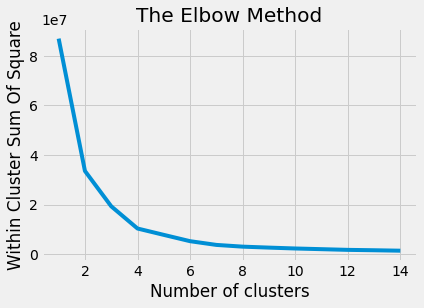

In [35]:
# start the clustering and try to find the optimal number of clusters 
within_cluster_sum_of_square=[]
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++')
    kmeans.fit(X)
    within_cluster_sum_of_square_iter = kmeans.inertia_
    within_cluster_sum_of_square.append(within_cluster_sum_of_square_iter)

kl = KneeLocator(range(1,15), within_cluster_sum_of_square, curve="convex", direction="decreasing")
print(kl.elbow)

plt.style.use("fivethirtyeight")
number_clusters = range(1,15)
plt.plot(number_clusters,within_cluster_sum_of_square)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum Of Square')

In [36]:
# implement the clustering techniques based on the optimal number of clusters 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

clusters = kmeans.fit_predict(X)

online_retail['Clusters'] = clusters
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Net_Sales,Variety,Clusters
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,761.0,1.0,130.00,29.0,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,1.0,1008.00,126.0,3
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,760.0,2.0,-20.40,28.0,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,761.0,21.0,603.94,148.0,3
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,760.0,2.0,-28.95,17.0,0


Tensorroc takes interaction matrix, user features matrix, and item feature matrix, so we need to calculate those before training the model

In [37]:
#interation matrix of the transaction that occured 
#check how much each customer purchased 
transaction_matrix = online_retail.groupby(['Customer ID', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Customer ID')
transaction_matrix.head()

scaler = preprocessing.MinMaxScaler()
transaction_matrix_scaled = scaler.fit_transform(transaction_matrix)
transaction_matrix_scaled = pd.DataFrame(transaction_matrix_scaled)

transaction_matrix_scaled.index = transaction_matrix.index
transaction_matrix_scaled.columns = transaction_matrix.columns

In [38]:
transaction_matrix_scaled

Description,PEACE WOODEN BLOCK LETTERS,VINTAGE DESIGN GIFT TAGS,WHITE CHERRY LIGHTS,15CM CHRISTMAS GLASS BALL 20 LIGHTS,6 CROCHET STRAWBERRIES,ANTIQUE SILVER TEA GLASS ETCHED,AREA PATROLLED METAL SIGN,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR MINI CASES,BAKING SET 9 PIECE RETROSPOT,BANQUET BIRTHDAY CARD,BATH BUILDING BLOCK WORD,BATHROOM METAL SIGN,BINGO SET,BIRD DECORATION RED SPOT,BISCUITS SMALL BOWL LIGHT BLUE,BLACK DINER WALL CLOCK,BLACK/BLUE DOTS RUFFLED UMBRELLA,BLUE FELT HANGING HEART W FLOWER,BLUE PADDED SOFT MOBILE,BOTANICAL LAVENDER BIRTHDAY CARD,CARROT CHARLIE+LOLA COASTER SET,CAT BOWL,CHARLIE & LOLA WASTEPAPER BIN BLUE,CHARLIE & LOLA WASTEPAPER BIN FLORA,CHARLIE + LOLA BISCUITS TINS,CHARLIE + LOLA RED HOT WATER BOTTLE,CHARLIE AND LOLA CHARLOTTE BAG,CHARLIE AND LOLA FIGURES TINS,CHARLIE LOLA BLUE HOT WATER BOTTLE,CHARLIE+LOLA PINK HOT WATER BOTTLE,CHARLIE+LOLA RED HOT WATER BOTTLE,"CHARLOTTE BAG , PINK/WHITE SPOTS",CHOCOLATE HOT WATER BOTTLE,CHRISTMAS CRAFT HEART DECORATIONS,CHRISTMAS CRAFT HEART STOCKING,CHRISTMAS CRAFT WHITE FAIRY,CHRISTMAS PUDDING TRINKET POT,CINAMMON & ORANGE WREATH,...,RETRO COFFEE MUGS ASSORTED,RETRO RED SPOTTY WASHING UP GLOVES,RETRO SPORT PARTY BAG + STICKER SET,RETRO SPOT CIGAR BOX MATCHES,RETRO SPOT LAMP,RETRO SPOT TEA SET CERAMIC 11 PC,RING OF ROSES BIRTHDAY CARD,SAVE THE PLANET MUG,SCOTTIE DOG HOT WATER BOTTLE,SET 12 RETRO WHITE CHALK STICKS,SET OF 3 BLACK FLYING DUCKS,SET OF 72 PINK HEART PAPER DOILIES,SET OF MEADOW FLOWER STICKERS,SET OF THREE VINTAGE GIFT WRAPS,SET/2 RED SPOTTY TEA TOWELS,SET/3 RED GINGHAM ROSE STORAGE BOX,SET/3 RUSSIAN DOLL STACKING TINS,SET/6 STRAWBERRY PAPER CUPS,SET/6 WOODLAND PAPER CUPS,SET/6 WOODLAND PAPER PLATES,SET3 BOOK BOX GREEN GINGHAM FLOWER,SILVER APERITIF GLASS,SMALL MARSHMALLOWS PINK BOWL,SPACE BOY BIRTHDAY CARD,STRAWBERRY CERAMIC TRINKET BOX,STRIPES DESIGN MONKEY DOLL,TOMATO CHARLIE+LOLA COASTER SET,UNION JACK GUNS & ROSES DOORMAT,UNION JACK HOT WATER BOTTLE,VICTORIAN GLASS HANGING T-LIGHT,VICTORIAN SEWING KIT,VINTAGE SNAKES & LADDERS,VINTAGE SNAP CARDS,VINYL RECORD FRAME SILVER,WHITE HANGING HEART T-LIGHT HOLDER,WHITE TALL PORCELAIN T-LIGHT HOLDER,WOODEN BOX ADVENT CALENDAR,WRAP BLUE RUSSIAN FOLKART,WRAP ENGLISH ROSE,YELLOW + BROWN BEAR FELT PURSE KIT
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
12636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
12682.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,1.0,1.0,0.0
13078.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
13085.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [39]:
#creating the user features where we choose to depend the country, the clusters, and the items that were bought
product_matrix = online_retail.groupby(['Customer ID', 'Description'])['Quantity'].nunique().unstack().reset_index().fillna(0).set_index('Customer ID')
product_matrix.head()

product_matrix_scaled = scaler.fit_transform(product_matrix)
product_matrix_scaled = pd.DataFrame(product_matrix_scaled)

product_matrix_scaled.index = product_matrix.index
product_matrix_scaled.columns = product_matrix.columns

cluster_matrix = online_retail.groupby(['Customer ID', 'Clusters'])['Clusters'].nunique().unstack().reset_index().fillna(0).set_index('Customer ID')
cluster_matrix.head()

country_matrix = online_retail.groupby(['Customer ID', 'Country'])['Country'].nunique().unstack().reset_index().fillna(0).set_index('Customer ID')
country_matrix.head()

user_matrix1 = pd.merge(product_matrix_scaled, cluster_matrix, left_index=True, right_index=True, how='inner')
user_matrix = pd.merge(user_matrix1, country_matrix, left_index=True, right_index=True, how='inner')
user_matrix = user_matrix.rename(columns={0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4'})

In [40]:
product_matrix_scaled

Description,PEACE WOODEN BLOCK LETTERS,VINTAGE DESIGN GIFT TAGS,WHITE CHERRY LIGHTS,15CM CHRISTMAS GLASS BALL 20 LIGHTS,6 CROCHET STRAWBERRIES,ANTIQUE SILVER TEA GLASS ETCHED,AREA PATROLLED METAL SIGN,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR MINI CASES,BAKING SET 9 PIECE RETROSPOT,BANQUET BIRTHDAY CARD,BATH BUILDING BLOCK WORD,BATHROOM METAL SIGN,BINGO SET,BIRD DECORATION RED SPOT,BISCUITS SMALL BOWL LIGHT BLUE,BLACK DINER WALL CLOCK,BLACK/BLUE DOTS RUFFLED UMBRELLA,BLUE FELT HANGING HEART W FLOWER,BLUE PADDED SOFT MOBILE,BOTANICAL LAVENDER BIRTHDAY CARD,CARROT CHARLIE+LOLA COASTER SET,CAT BOWL,CHARLIE & LOLA WASTEPAPER BIN BLUE,CHARLIE & LOLA WASTEPAPER BIN FLORA,CHARLIE + LOLA BISCUITS TINS,CHARLIE + LOLA RED HOT WATER BOTTLE,CHARLIE AND LOLA CHARLOTTE BAG,CHARLIE AND LOLA FIGURES TINS,CHARLIE LOLA BLUE HOT WATER BOTTLE,CHARLIE+LOLA PINK HOT WATER BOTTLE,CHARLIE+LOLA RED HOT WATER BOTTLE,"CHARLOTTE BAG , PINK/WHITE SPOTS",CHOCOLATE HOT WATER BOTTLE,CHRISTMAS CRAFT HEART DECORATIONS,CHRISTMAS CRAFT HEART STOCKING,CHRISTMAS CRAFT WHITE FAIRY,CHRISTMAS PUDDING TRINKET POT,CINAMMON & ORANGE WREATH,...,RETRO COFFEE MUGS ASSORTED,RETRO RED SPOTTY WASHING UP GLOVES,RETRO SPORT PARTY BAG + STICKER SET,RETRO SPOT CIGAR BOX MATCHES,RETRO SPOT LAMP,RETRO SPOT TEA SET CERAMIC 11 PC,RING OF ROSES BIRTHDAY CARD,SAVE THE PLANET MUG,SCOTTIE DOG HOT WATER BOTTLE,SET 12 RETRO WHITE CHALK STICKS,SET OF 3 BLACK FLYING DUCKS,SET OF 72 PINK HEART PAPER DOILIES,SET OF MEADOW FLOWER STICKERS,SET OF THREE VINTAGE GIFT WRAPS,SET/2 RED SPOTTY TEA TOWELS,SET/3 RED GINGHAM ROSE STORAGE BOX,SET/3 RUSSIAN DOLL STACKING TINS,SET/6 STRAWBERRY PAPER CUPS,SET/6 WOODLAND PAPER CUPS,SET/6 WOODLAND PAPER PLATES,SET3 BOOK BOX GREEN GINGHAM FLOWER,SILVER APERITIF GLASS,SMALL MARSHMALLOWS PINK BOWL,SPACE BOY BIRTHDAY CARD,STRAWBERRY CERAMIC TRINKET BOX,STRIPES DESIGN MONKEY DOLL,TOMATO CHARLIE+LOLA COASTER SET,UNION JACK GUNS & ROSES DOORMAT,UNION JACK HOT WATER BOTTLE,VICTORIAN GLASS HANGING T-LIGHT,VICTORIAN SEWING KIT,VINTAGE SNAKES & LADDERS,VINTAGE SNAP CARDS,VINYL RECORD FRAME SILVER,WHITE HANGING HEART T-LIGHT HOLDER,WHITE TALL PORCELAIN T-LIGHT HOLDER,WOODEN BOX ADVENT CALENDAR,WRAP BLUE RUSSIAN FOLKART,WRAP ENGLISH ROSE,YELLOW + BROWN BEAR FELT PURSE KIT
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12682.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
13078.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13085.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0

In [41]:
# item matrix include the quantities of the product
item_matrix = pd.DataFrame(online_retail.groupby(['Description','StockCode'])['Quantity'].sum().unstack().fillna(0).reset_index().set_index('Description'))

item_matrix_scaled = scaler.fit_transform(item_matrix)
item_matrix_scaled = pd.DataFrame(item_matrix_scaled)

item_matrix_scaled.index = item_matrix.index
item_matrix_scaled.columns = item_matrix.columns

In [42]:
# converting feature matrix into sparse matrix for the model to accept them
interaction_f = sparse.coo_matrix(transaction_matrix_scaled )
user_f  = sparse.coo_matrix(user_matrix) 
item_f  = sparse.coo_matrix(item_matrix_scaled)

In [43]:
def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [44]:

mask_size = len(interaction_f.data)

### use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([ True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [45]:
# Create a masked train and test dataset of the interaction features
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

In [46]:
!pip install 'tensorflow<2.0'

     |████████████████████████████████| 110.5 MB 1.1 kB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 2.9 MB 44.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 503 kB 41.6 MB/s 
     |████████████████████████████████| 3.8 MB 46.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=cbaa1c9060797945cd76e00519cd1b2b2ddcf6347f35f14182aedfacc1753800
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

In [74]:
# Build the model with default parameters
model = tensorrec.TensorRec()

# Fit the model for 2 epochs
model.fit(train_interactions, 
          user_features, 
          item_features, epochs=2, verbose=True)

# Predict scores and ranks for all users and all items
predictions = model.predict(user_features=user_features,
                            item_features=item_features)
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
## but since we only have 92 products, k=80 may sounds fitting.
r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=100)
r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=100)
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Recall at @k: Train: 0.57 Test: 0.90


In [75]:
# produce the ranking into a readable table (dataframe it is)
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = item_matrix_scaled.index
ranks_df.index = user_matrix.index
ranks_df = ranks_df.T

In [76]:
ranks_df 

Customer ID,12362.0,12636.0,12682.0,13078.0,13085.0,13635.0,13758.0,14110.0,15362.0,15413.0,16321.0,17519.0,17592.0,18087.0,18102.0
Description,,,,,,,,,,,,,,,
PEACE WOODEN BLOCK LETTERS,35,33,33,34,27,33,32,30,29,29,30,30,30,31,35
VINTAGE DESIGN GIFT TAGS,45,48,124,45,41,48,50,46,41,47,45,40,53,43,47
WHITE CHERRY LIGHTS,82,64,44,77,86,64,59,90,87,89,65,84,79,91,104
15CM CHRISTMAS GLASS BALL 20 LIGHTS,54,51,41,62,57,57,55,57,58,65,55,65,57,56,59
6 CROCHET STRAWBERRIES,64,110,43,61,62,61,60,72,56,72,59,72,88,60,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WHITE TALL PORCELAIN T-LIGHT HOLDER,113,118,65,122,112,113,110,120,96,140,111,117,120,117,132
WOODEN BOX ADVENT CALENDAR,67,78,115,80,116,104,87,103,130,100,101,114,129,109,81
WRAP BLUE RUSSIAN FOLKART,47,43,113,46,42,41,43,44,44,42,41,41,56,42,42
